## Clustering

To quickly determine if the property data has easily-distinguishable groups, I employed two different unsupervised clustering techniques, KMeans and Mean Shift. I first normalized the data and used PCA to reduce the dimensionality down to just two features for easy visualization. I then plotted the changes in distortion as the number of clusters increased in an attempt to use the elbow method to identify the optimal $k$. Next, I took the optimal $k$ from the elbow method and plotted the silhouette coefficients for each cluster. Lastly, I used Mean Shift to attempt to ascertain clusters.

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# Read in the data
df = pd.read_hdf('../data/processed/bexar_processed.h5')

In [3]:
# Fill na values in with 1 in crim_prop with 0 so they don't get dropped later on
df.loc[df.crim_prop==1,'price_psf'] = df.loc[df.crim_prop==1,'price_psf'].fillna(0)

trim_prop_df = df[(df.price_psf<df.price_psf.quantile(.999)) | (df.price_psf.isna())]
trim_prop_df.shape

(620929, 78)

In [4]:
# Grab all columns that are under the 70,000 nan limit
nan_limit = 70000
check_nan = trim_prop_df.isnull().sum()

variables_list = check_nan[check_nan<nan_limit].index
variables_list = variables_list[variables_list.isin(trim_prop_df.columns[trim_prop_df.dtypes!='object'])]
variables_list = variables_list.drop([
    'prop_id','py_owner_id','py_addr_zip_cass','prop_val_yr','appraised_val',
    'Prior_Mkt_Val','bexar_2015_market_value','bexar_2016_market_value', 
    'bexar_2017_market_value','bexar_2018_market_value','owner_zip_code',
    'property_zip','neighborhood_code'
])

sub_df = trim_prop_df[variables_list]
sub_df = sub_df.dropna()

In [5]:
X = sub_df.iloc[:,:-1]
y = sub_df.crim_prop

##### Reduce Dimensionality and Visualize

In [6]:
X_norm = normalize(X)
X_pca = PCA(2).fit_transform(X_norm)

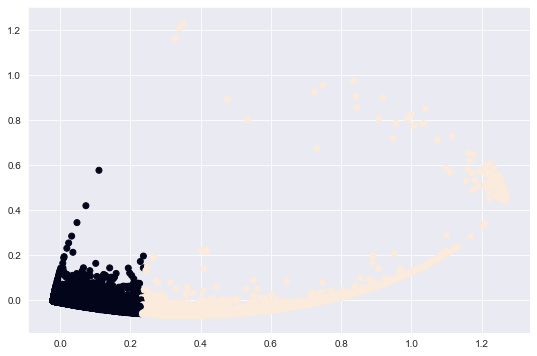

Comparing k-means clusters against the data:
crim_prop     0.0  1.0
row_0                 
0          526104   40
1            4772    7


In [7]:
km = KMeans(
    n_clusters=2,
    init='k-means++',
    random_state=42
)

y_km = km.fit_predict(X_pca)

# Plot the solution.
plt.figure(figsize=(9,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_km)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_km,y))

With the features reduced to just two, it does not appear there are distinguishable clusters. From the crosstab data, KMeans is only correctly classifying 7 of the 47 criminal properties.

##### Elbow Method with Distortion Plot

The elbow method may reveal the optimal number of clusters. Distortion will decrease as $k$ increases as the samples will be closer to their centroids. Therefore, identifying the value of $k$ where the rate of change of distortion begins to decrease more slowly will allow for an estimation of the optimal $k$.

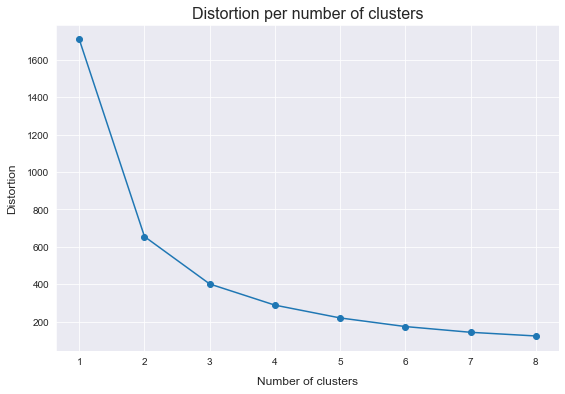

In [8]:
skip = 0
if skip == 0:
    distortions = []
    for i in range(1, 9):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    random_state=3)
        km.fit(X_norm)
        distortions.append(km.inertia_)
        
    plt.figure(figsize=(9,6))
    plt.plot(range(1, 9), distortions, marker='o')
    plt.xlabel('Number of clusters',labelpad=10,fontsize=12)
    plt.ylabel('Distortion',labelpad=10,fontsize=12)
    plt.title('Distortion per number of clusters',fontsize=16)
    plt.show()

Based on the change in the slope of the above plot, it appeara that k=3 or k=2 is the optimal number of clusters.

In [9]:
# Grab a sample for time purposes
X_norm_df = pd.DataFrame(data=X_norm)
X_norm_sample = X_norm_df.sample(frac=0.075)
X_norm_sample.shape

(39819, 28)

##### Silhouette Plots

The mean of the silhouette coefficients for each cluster will provide an idea of how similar the datapoins in each cluster are.

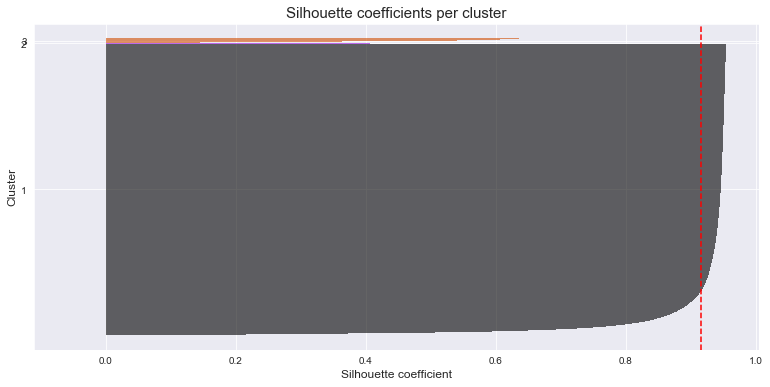

In [10]:
skip = 0
if skip == 0:
    plt.figure(figsize=(13,6))
    km = KMeans(n_clusters=3,
                init='k-means++',
                random_state=3)
    y_km = km.fit_predict(X_norm_sample)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X_norm_sample, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, j in enumerate(cluster_labels):
        j_silhouette_vals = silhouette_vals[y_km == j]
        j_silhouette_vals.sort()
        y_ax_upper += len(j_silhouette_vals)
        color = cm.gnuplot(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                 j_silhouette_vals,
                 height=1.0,
                 edgecolor='none',
                 color=color,
                 alpha=0.6
                )
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(j_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color='red',
                linestyle='--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster',fontsize=12)
    plt.xlabel('Silhouette coefficient',fontsize=12)
    plt.title('Silhouette coefficients per cluster',fontsize=15)
    plt.show()

On the positive side, each cluster appears to be made up of relatively similar data points, because each cluster's mean silhouette coefficient is well above 0. However, it is apparent that cluster 1 is far larger than the other two and has a much higher average silhouette coefficient. This indicates that, despite what the elbow method with distortions showed above, k=3 makes for suboptimal clustering.

##### Mean Shift

With no previous assumptions made about the number of clusters, Mean Shift may provide a clearer picture of the clusters in the data.

In [11]:
# Bandwidth doesn't scale well, so I will manually gridsearch
bandwidths = [0.1,0.2,0.3,0.5,0.75,1,2]

for i in bandwidths:
    ms = MeanShift(bandwidth=i, bin_seeding=True)
    ms.fit(X_norm)

    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    n_clusters_ = len(np.unique(labels))
    print('Number of estimated clusters: {0} with bandwidth={1}'.format(n_clusters_,i))

Number of estimated clusters: 36 with bandwidth=0.1
Number of estimated clusters: 15 with bandwidth=0.2
Number of estimated clusters: 7 with bandwidth=0.3
Number of estimated clusters: 2 with bandwidth=0.5
Number of estimated clusters: 1 with bandwidth=0.75
Number of estimated clusters: 1 with bandwidth=1
Number of estimated clusters: 1 with bandwidth=2


Higher bandwidths "smooth out" more potential clusters. It is clear here the number of clusters Mean Shift detects drops rapidly as the bandwidth increases.

##### Final Notes

- Reducing the dimensionality of the data did not reveal clean clusters. 
- Although plotting the change in distortion over an increasing number of clusters would indicate k=3 may be optimal, the plot of each cluster's silhouette coefficients shows otherwise. It appears there is one very large cluster of data that are all rather similar and then two other, smaller clusters with data that is slightly less similar.